# Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import random
import os
import glob
import zipfile

import cv2
from PIL import Image
import albumentations as A

import tensorflow as tf
from keras.applications.vgg16 import VGG16
from keras.layers import Dense, Input, Flatten, Conv2D, MaxPooling2D
from keras.models import Model, Sequential
from keras.optimizers import Adam
from tensorflow.python.ops.math_ops import reduce_prod


AUTOTUNE = tf.data.AUTOTUNE


# Check GPU

In [2]:
print(tf.__version__)
print("Num GPUs Available: ", len(tf.config.list_physical_devices("GPU")))


2.9.2
Num GPUs Available:  1


# Setting seeds

In [3]:
seed = 42


def seed_everything(seed=seed):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)


seed_everything()


# Download dataset

In [4]:
!kaggle datasets download --force -d jessicali9530/celeba-dataset


  0%|          | 0.00/1.33G [00:00<?, ?B/s]
  0%|          | 1.00M/1.33G [00:00<03:56, 6.02MB/s]
  0%|          | 2.00M/1.33G [00:00<03:51, 6.17MB/s]
  0%|          | 3.00M/1.33G [00:00<03:40, 6.46MB/s]
  0%|          | 4.00M/1.33G [00:00<03:39, 6.48MB/s]
  0%|          | 5.00M/1.33G [00:00<03:39, 6.49MB/s]
  0%|          | 6.00M/1.33G [00:00<03:40, 6.46MB/s]
  1%|          | 7.00M/1.33G [00:01<03:40, 6.44MB/s]
  1%|          | 8.00M/1.33G [00:01<03:39, 6.46MB/s]
  1%|          | 9.00M/1.33G [00:01<03:36, 6.55MB/s]
  1%|          | 10.0M/1.33G [00:01<03:34, 6.60MB/s]
  1%|          | 11.0M/1.33G [00:01<03:34, 6.59MB/s]
  1%|          | 12.0M/1.33G [00:01<03:33, 6.61MB/s]
  1%|          | 13.0M/1.33G [00:02<03:33, 6.61MB/s]
  1%|          | 14.0M/1.33G [00:02<03:37, 6.49MB/s]
  1%|          | 15.0M/1.33G [00:02<03:39, 6.44MB/s]
  1%|          | 16.0M/1.33G [00:02<03:42, 6.35MB/s]
  1%|          | 17.0M/1.33G [00:02<03:42, 6.33MB/s]
  1%|▏         | 18.0M/1.33G [00:02<03:37, 6.47MB/s]
 

In [5]:
dataset = zipfile.ZipFile("celeba-dataset.zip")
dataset.extractall("dataset")


# Paths

In [6]:
path_image_dataset = "dataset/img_align_celeba/"
path_csv = "dataset/list_landmarks_align_celeba.csv"
img_files = glob.glob(f"{path_image_dataset}/*/*")


# Hyperparameters and constants

In [7]:
first_image = cv2.imread(img_files[0])
default_height, default_width = first_image.shape[:2]
default_height, default_width


(218, 178)

In [8]:
target_width = 100
target_height = 100
IMG_SIZE = (target_width, target_height)
BATCH_SIZE = 256
EPOCHS = 1


# EDA

In [9]:
landmarks = pd.read_csv(path_csv)
landmarks.sample(3)


image_id  lefteye_x  lefteye_y  righteye_x  righteye_y  nose_x  \
93241   093242.jpg         70        108         105         112      98   
121413  121414.jpg         69        111         108         112      89   
10624   010625.jpg         70        111         108         111      92   

        nose_y  leftmouth_x  leftmouth_y  rightmouth_x  rightmouth_y  
93241      127           77          153           104           154  
121413     129           74          152           104           152  
10624      141           73          152           103           153

In [10]:
landmarks_lips = landmarks.drop(
    columns=[
        "lefteye_x",
        "lefteye_y",
        "righteye_x",
        "righteye_y",
        "nose_x",
        "nose_y",
        "image_id",
    ],
)
landmarks_lips = landmarks_lips.rename(
    {
        "leftmouth_y": "y_min",
        "leftmouth_x": "x_min",
        "rightmouth_y": "y_max",
        "rightmouth_x": "x_max",
    },
    axis=1,
)
landmarks_lips.sample(3)


x_min  y_min  x_max  y_max
173803     75    154    102    154
70565      68    150    108    151
108725     74    152    103    152

## Images with bounding boxes

In [11]:
def view_image_from_file(file_names, xy):
    fig = plt.figure(figsize=(22, 22))
    number_of_images = len(file_names)
    for i, file in enumerate(file_names):
        img = Image.open(img_files[file])
        ax = fig.add_subplot(number_of_images // 2, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(img), (xy[i][0], xy[i][1]), (xy[i][2], xy[i][3]), (0, 255, 0), 1
        )
        ax.imshow(np.array(img, np.int32))


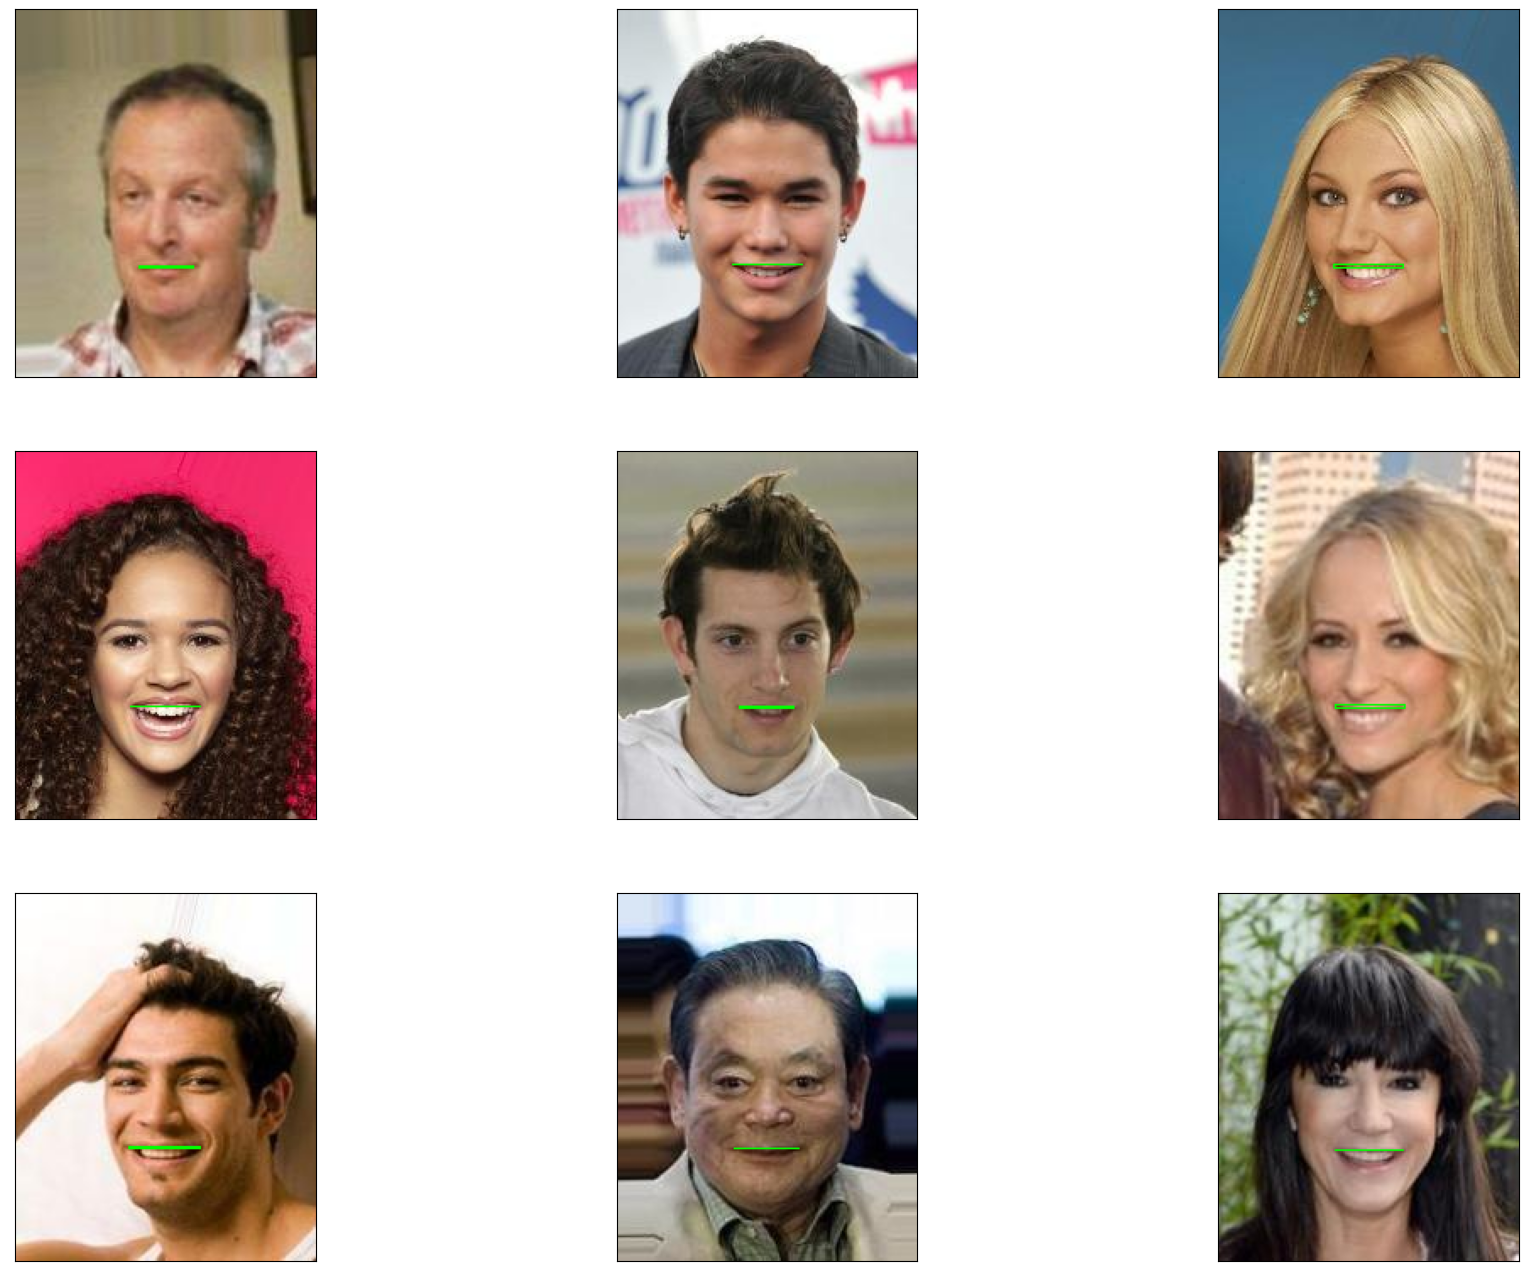

In [12]:
example_num_start = 6000
example_num_end = 6009
view_image_from_file(
    file_names=landmarks_lips.index[example_num_start:example_num_end],
    xy=landmarks_lips.values[example_num_start:example_num_end],
)


### Boundig boxes have misleading coordinates. Let's try to repair them.

In [13]:
landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]


x_min  y_min  x_max  y_max
3          71    155    101    151
5          74    154    102    153
6          72    152    104    152
7          73    155    104    153
8          66    152    109    150
...       ...    ...    ...    ...
202589     73    152    104    152
202590     67    152    110    151
202593     74    153    103    151
202595     66    150    110    150
202597     71    153    106    151

[122548 rows x 4 columns]

In [14]:
landmarks_lips.loc[landmarks_lips["x_min"] >= landmarks_lips["x_max"]]


Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

In [15]:
BIAS = 10
landmarks_lips["y_min"] = landmarks["leftmouth_y"].add(-BIAS)
landmarks_lips["y_max"] = landmarks["rightmouth_y"].add(+BIAS)
landmarks_lips.head()


x_min  y_min  x_max  y_max
0     73    142    108    164
1     70    141    108    163
2     74    146     98    168
3     71    145    101    161
4     71    137    104    160

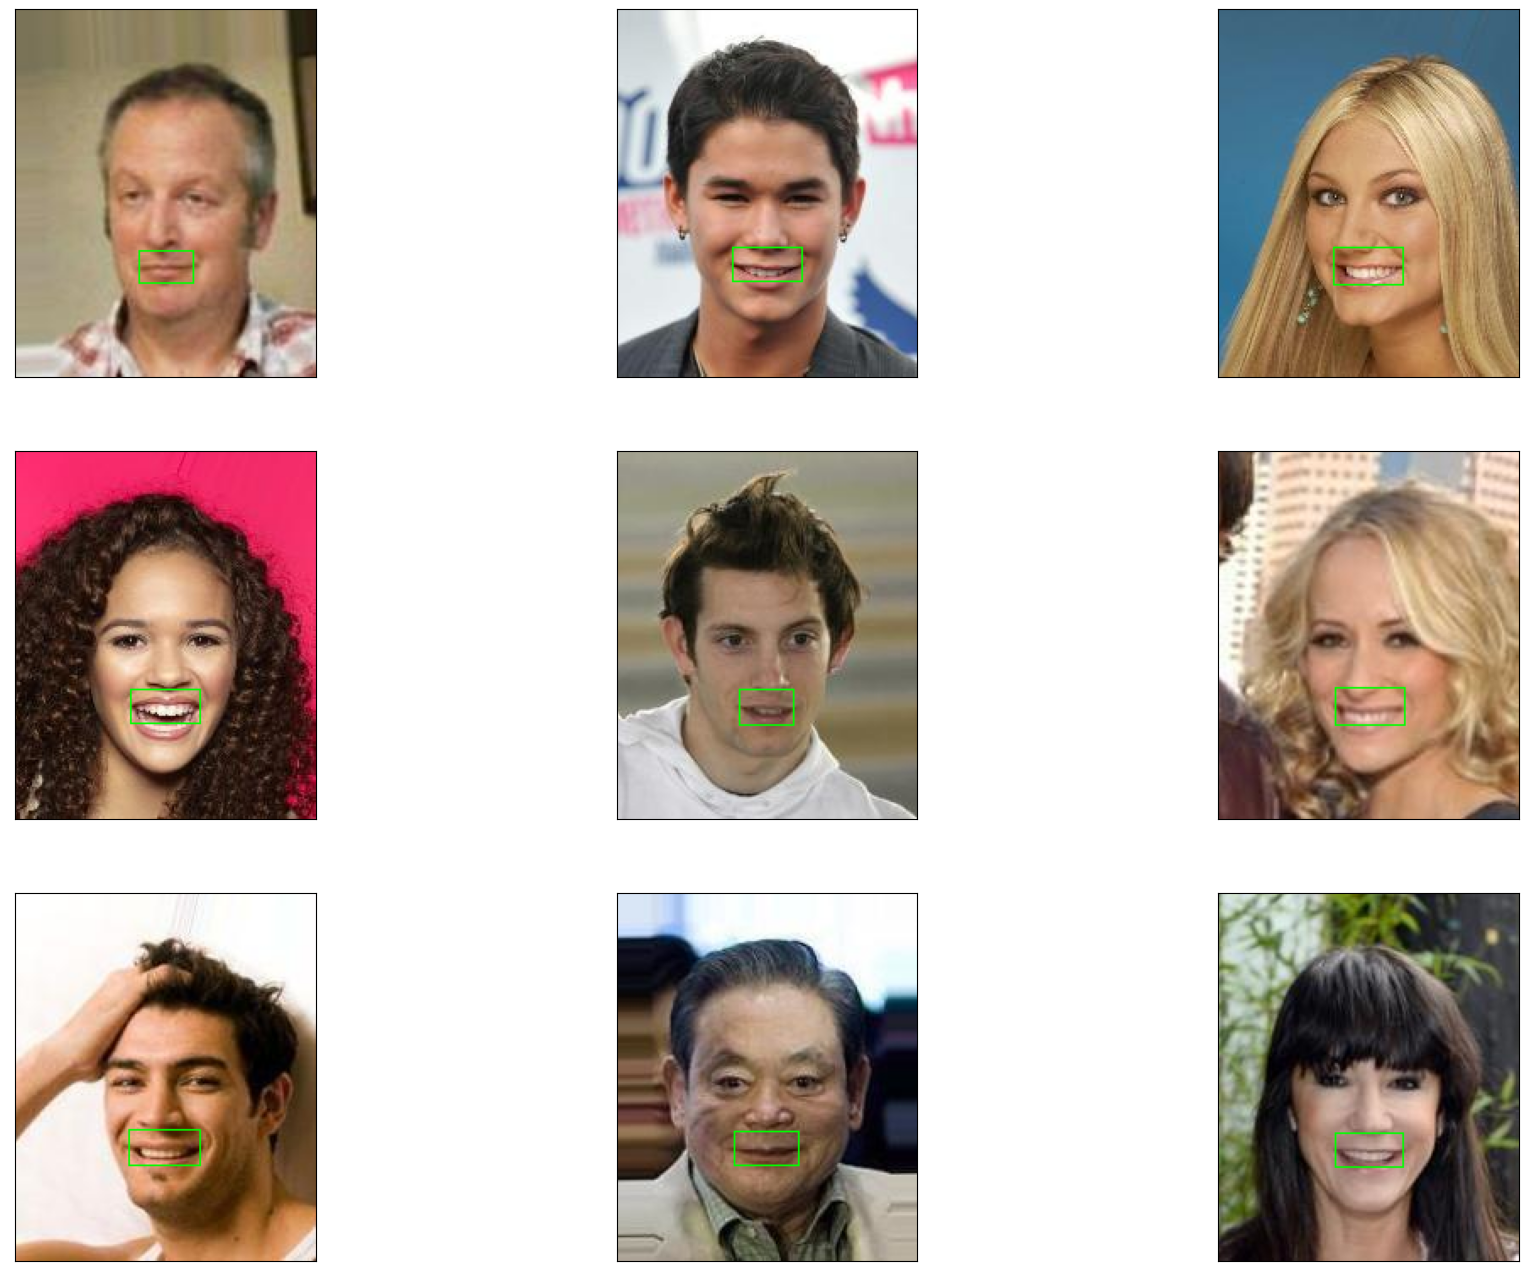

In [16]:
view_image_from_file(
    file_names=landmarks_lips.index[example_num_start:example_num_end],
    xy=landmarks_lips.values[example_num_start:example_num_end],
)


In [17]:
# We dont want to have equal values or min values to be higher than max
incorrect_values = landmarks_lips.loc[
    (landmarks_lips["y_min"] >= landmarks_lips["y_max"])
    | (landmarks_lips["x_min"] >= landmarks_lips["x_max"])
]
incorrect_values


x_min  y_min  x_max  y_max
24978      76    150     94    150
145109     64    159    104    153

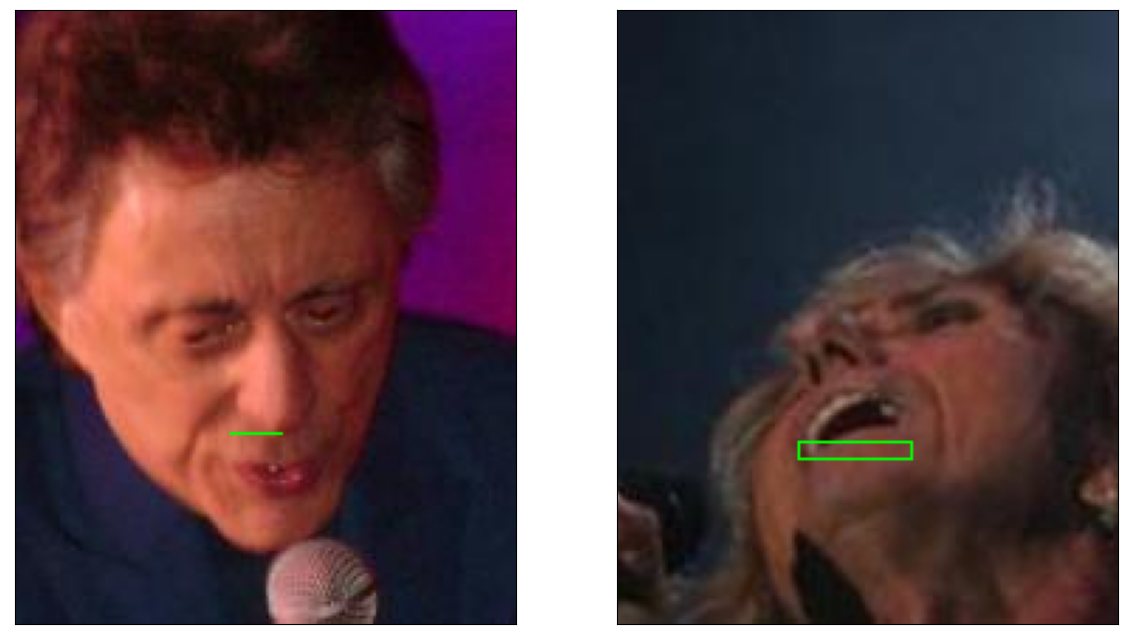

In [18]:
view_image_from_file(file_names=incorrect_values.index, xy=incorrect_values.values)


### Because we have only 2 images with wrong coordinates we can try to fix them manualy

I did some improvements by trial and error ;)


In [19]:
incorrect_values.iloc[0]["x_max"] = incorrect_values.iloc[0]["x_max"] + (15)
incorrect_values.iloc[0]["y_max"] = incorrect_values.iloc[0]["y_max"] + (20)
incorrect_values.iloc[0]["y_min"] = incorrect_values.iloc[0]["y_min"] + (5)

incorrect_values.iloc[1]["y_min"] = incorrect_values.iloc[1]["y_min"] - (30)
incorrect_values.iloc[1]["y_max"] = incorrect_values.iloc[1]["y_max"] + (10)
incorrect_values


x_min  y_min  x_max  y_max
24978      76    155    109    170
145109     64    129    104    163

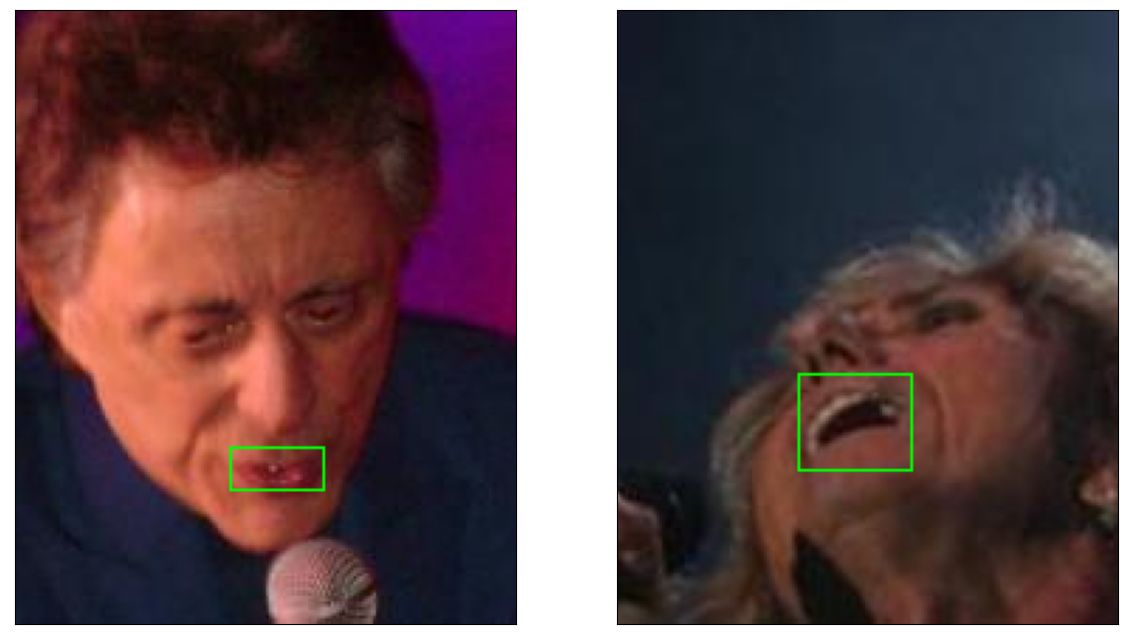

In [20]:
view_image_from_file(file_names=incorrect_values.index, xy=incorrect_values.values)


### Seems pretty good so we can do the same operations on the right DataFrame

In [21]:
landmarks_lips.iloc[incorrect_values.index[0]]["x_max"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["x_max"] + (15)
landmarks_lips.iloc[incorrect_values.index[0]]["y_max"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["y_max"] + (20)
landmarks_lips.iloc[incorrect_values.index[0]]["y_min"] = landmarks_lips.iloc[
    incorrect_values.index[0]
]["y_min"] + (5)

landmarks_lips["y_min"].iloc[incorrect_values.index[1]] = landmarks_lips["y_min"].iloc[
    incorrect_values.index[1]
] - (30)
landmarks_lips["y_max"].iloc[incorrect_values.index[1]] = landmarks_lips["y_max"].iloc[
    incorrect_values.index[1]
] + (10)


In [22]:
incorrect_values = landmarks_lips.loc[
    landmarks_lips["y_min"] >= landmarks_lips["y_max"]
]
incorrect_values


Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

### Let's do last sanity check. 24978, 145109 are ids of our incorrect images.

In [23]:
sanity_check = landmarks_lips.iloc[[24978, 145109], :]


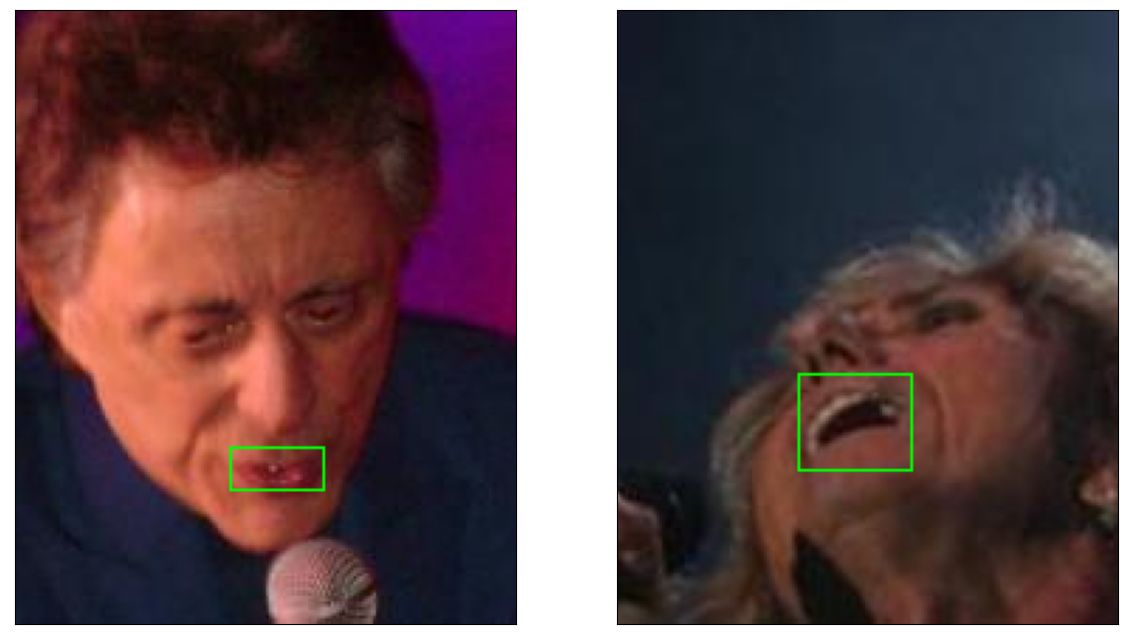

In [24]:
view_image_from_file(file_names=sanity_check.index, xy=sanity_check.values)


In [25]:
landmarks_lips.loc[landmarks_lips["y_min"] >= landmarks_lips["y_max"]]


Empty DataFrame
Columns: [x_min, y_min, x_max, y_max]
Index: []

In [26]:
landmarks_lips


x_min  y_min  x_max  y_max
0          73    142    108    164
1          70    141    108    163
2          74    146     98    168
3          71    145    101    161
4          71    137    104    160
...       ...    ...    ...    ...
202594     73    141    104    163
202595     66    140    110    160
202596     68    141    109    163
202597     71    143    106    161
202598     75    140    103    162

[202599 rows x 4 columns]

# Normalize coordinates to 0-1 range

In [27]:
landmarks_lips_normalized = landmarks_lips[["x_min", "x_max"]].div(default_width)
landmarks_lips_normalized[["y_min", "y_max"]] = landmarks_lips[["y_min", "y_max"]].div(
    default_height
)
landmarks_lips_normalized


x_min     x_max     y_min     y_max
0       0.410112  0.606742  0.651376  0.752294
1       0.393258  0.606742  0.646789  0.747706
2       0.415730  0.550562  0.669725  0.770642
3       0.398876  0.567416  0.665138  0.738532
4       0.398876  0.584270  0.628440  0.733945
...          ...       ...       ...       ...
202594  0.410112  0.584270  0.646789  0.747706
202595  0.370787  0.617978  0.642202  0.733945
202596  0.382022  0.612360  0.646789  0.747706
202597  0.398876  0.595506  0.655963  0.738532
202598  0.421348  0.578652  0.642202  0.743119

[202599 rows x 4 columns]

## Reorganize columns order

In [28]:
cols = landmarks_lips_normalized.columns.tolist()
cols = [cols[0], cols[2], cols[1], cols[3]]
landmarks_lips_normalized = landmarks_lips_normalized[cols]


In [29]:
landmarks_lips_normalized


x_min     y_min     x_max     y_max
0       0.410112  0.651376  0.606742  0.752294
1       0.393258  0.646789  0.606742  0.747706
2       0.415730  0.669725  0.550562  0.770642
3       0.398876  0.665138  0.567416  0.738532
4       0.398876  0.628440  0.584270  0.733945
...          ...       ...       ...       ...
202594  0.410112  0.646789  0.584270  0.747706
202595  0.370787  0.642202  0.617978  0.733945
202596  0.382022  0.646789  0.612360  0.747706
202597  0.398876  0.655963  0.595506  0.738532
202598  0.421348  0.642202  0.578652  0.743119

[202599 rows x 4 columns]

In [30]:
landmarks_lips = landmarks_lips.values.tolist()
landmarks_lips_normalized = landmarks_lips_normalized.values.tolist()


# Load images from directory

In [31]:
data = tf.keras.utils.image_dataset_from_directory(
    path_image_dataset,
    batch_size=None,
    image_size=IMG_SIZE,
    labels=landmarks_lips_normalized,
    shuffle=False,
)
print(data)


Found 202599 files belonging to 1 classes.
<PrefetchDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>


In [32]:
def view_image_from_dataset(ds, number_of_samples):
    fig = plt.figure(figsize=(22, 22))
    images = ds.take(number_of_samples)
    for i, file in enumerate(images):
        ax = fig.add_subplot(number_of_samples // 2, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(file[0]),
            (int(file[1][0] * 100), int(file[1][1] * 100)),
            (int(file[1][2] * 100), int(file[1][3] * 100)),
            (0, 255, 0),
            1,
        )
        ax.set_title(
            f"boundig box:({int(file[1][0]*100)},{int(file[1][1]*100)})({int(file[1][2]*100)},{int(file[1][3]*100)})",
            fontsize=15,
        )
        ax.imshow(np.array(img, np.int32))


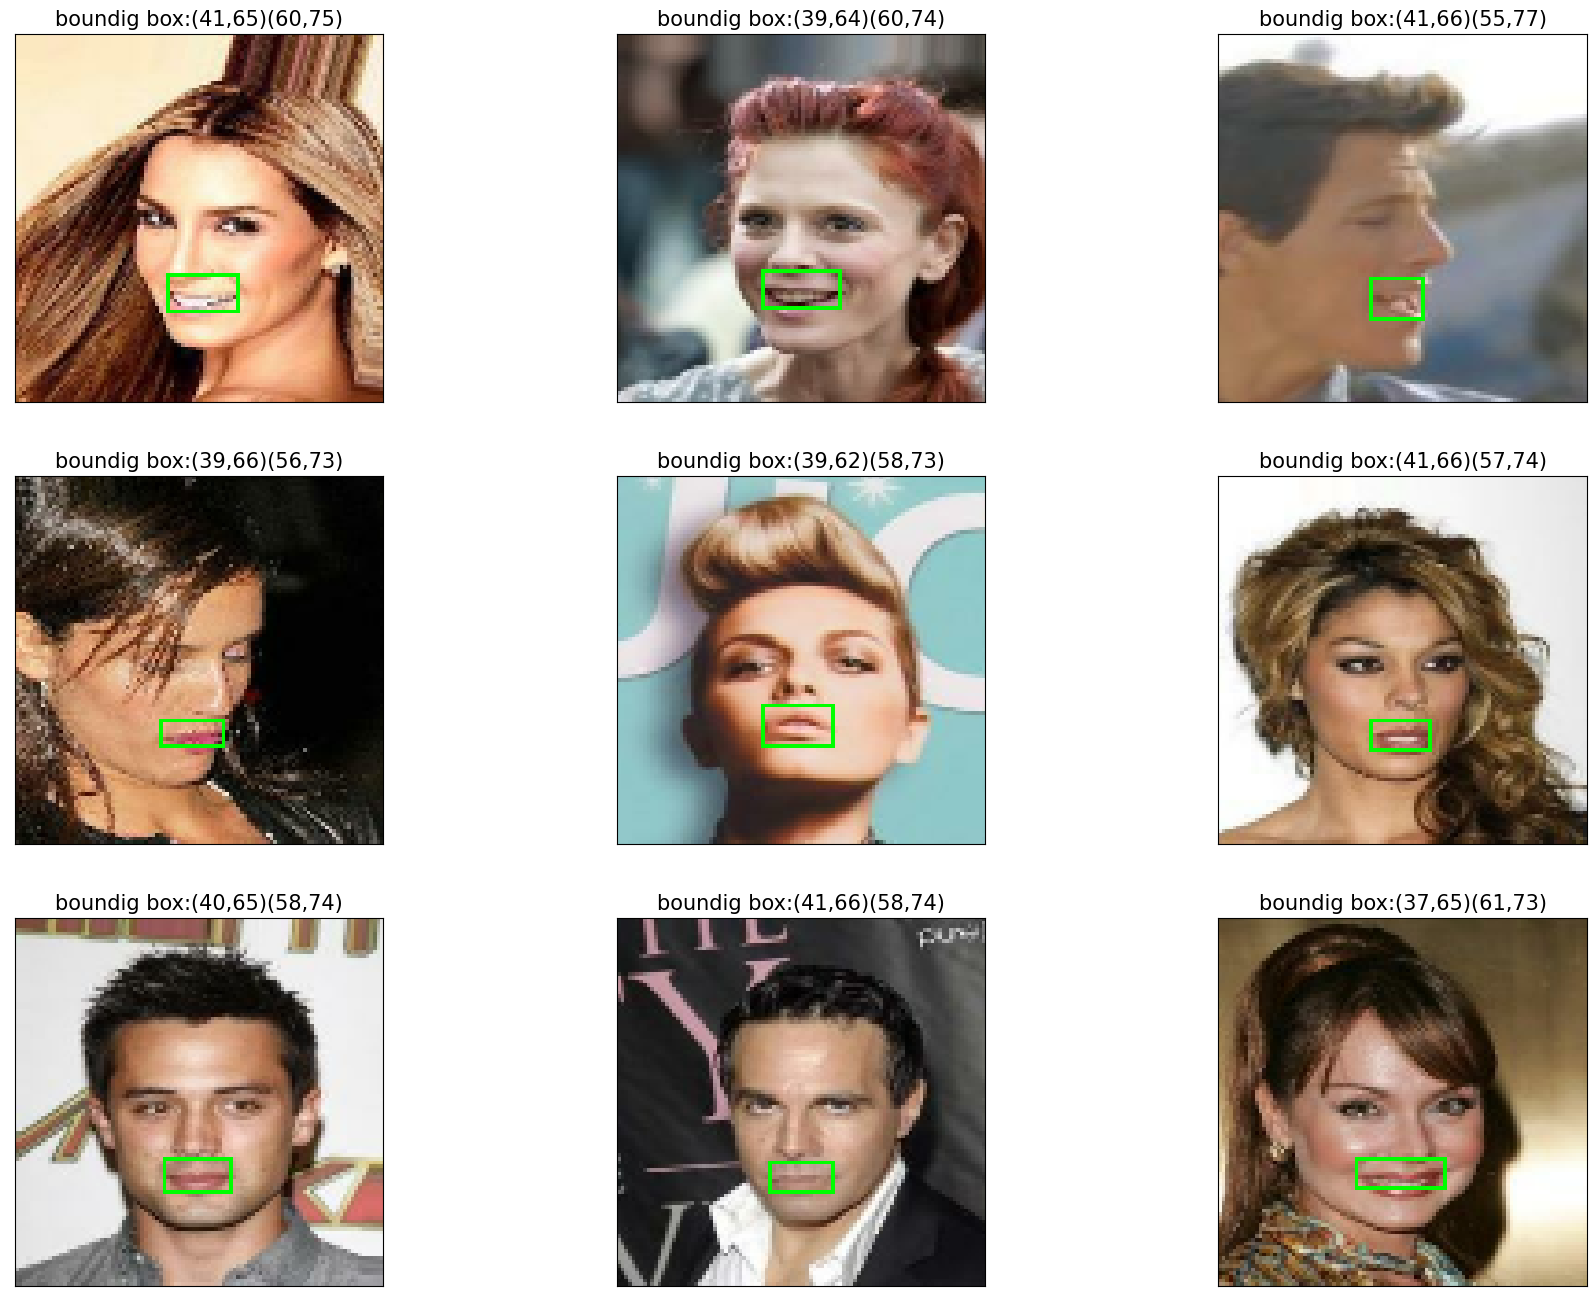

In [33]:
view_image_from_dataset(data, 9)


# Split dataset to 3 parts:
- train 80%
- validation 15% 
- test 5%

In [34]:
train_size = int(len(img_files) * 0.8)
val_size = int(len(img_files) * 0.15)
test_size = int(len(img_files) - (train_size + val_size))
train_size, val_size, test_size


(162079, 30389, 10131)

In [35]:
train_size + val_size + test_size, len(img_files)


(202599, 202599)

In [36]:
train = data.take(train_size)
val = data.skip(train_size)
val = val.take(val_size)
test = data.skip(train_size + val_size)


In [37]:
len(train), len(val), len(test)


(162079, 30389, 10131)

# Create augmentation and normalization functions

In [38]:
def normalization(image, label):
    image_final = tf.image.convert_image_dtype(image, tf.float32) / 255
    return image_final, label


In [39]:
class_labels = np.zeros(
    1
)  # it's only needed for albuminations - this module needs some kind of label so we will give number 0
propability = 0.5
transform = A.Compose(
    [
        A.Rotate(limit=180, p=propability),
        A.RandomBrightnessContrast(p=propability),
        A.ImageCompression(quality_lower=85, quality_upper=100, p=propability),
        A.HueSaturationValue(
            hue_shift_limit=20, sat_shift_limit=30, val_shift_limit=20, p=propability
        ),
        A.HorizontalFlip(p=propability),
        A.VerticalFlip(p=propability),
        A.ISONoise(p=propability),
        A.MotionBlur(p=propability),
        A.Perspective(p=propability),
        A.Affine(p=propability),
    ],
    bbox_params=A.BboxParams(
        format="albumentations", min_visibility=0.3, label_fields=["class_labels"]
    ),
)


In [40]:
def augmentation_normalization(img, label):
    transformed = transform(
        image=np.asarray(img, dtype=np.uint8),
        bboxes=[label.tolist()],
        class_labels=[class_labels],
    )
    aug_img = transformed["image"] / 255
    aug_bbox = transformed["bboxes"]

    return np.asarray(aug_img, dtype=np.float32), np.asarray(aug_bbox, dtype=np.float32)


def process_data(image, label):
    aug = tf.numpy_function(
        func=augmentation_normalization,
        inp=[image, label],
        Tout=(np.float32, np.float32),
    )
    return aug[0], aug[1]


def set_shapes(img, label):
    label.set_shape([4])
    return img, tf.squeeze(label)


# Prepare data with and without augmentation

In [41]:
train_augmented = train.map(process_data, num_parallel_calls=AUTOTUNE)
train_augmented = train_augmented.map(set_shapes)
train_augmented


<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [42]:
train_no_aug = train.map(normalization, num_parallel_calls=AUTOTUNE)
train_no_aug


<ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [43]:
val_augmented = val.map(process_data, num_parallel_calls=AUTOTUNE)
val_augmented = val_augmented.map(set_shapes)
val_augmented


<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [44]:
val_no_aug = val.map(normalization, num_parallel_calls=AUTOTUNE)
val_no_aug


<ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [45]:
test_augmented = test.map(process_data, num_parallel_calls=AUTOTUNE)
test_augmented = test_augmented.map(set_shapes)
test_augmented


<MapDataset element_spec=(TensorSpec(shape=<unknown>, dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

In [46]:
test_no_aug = test.map(normalization, num_parallel_calls=AUTOTUNE)
test_no_aug


<ParallelMapDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None))>

## Take a look at augmented images

In [47]:
def view_augmented_image_from_dataset(ds, number_of_samples):
    fig = plt.figure(figsize=(22, 22))
    ds = ds.take(number_of_samples)
    for i, file in enumerate(ds):
        ax = fig.add_subplot(3, 3, i + 1, xticks=[], yticks=[])
        img = cv2.rectangle(
            np.asarray(file[0] * 255),
            (int(file[1][0] * 100), int(file[1][1] * 100)),
            (int(file[1][2] * 100), int(file[1][3] * 100)),
            (0, 255, 0),
            1,
        )
        ax.set_title(
            f"boundig box:({int(file[1][0]*100)},{int(file[1][1]*100)})({int(file[1][2]*100)},{int(file[1][3]*100)})",
            fontsize=15,
        )
        ax.imshow(np.array(img, np.int32))


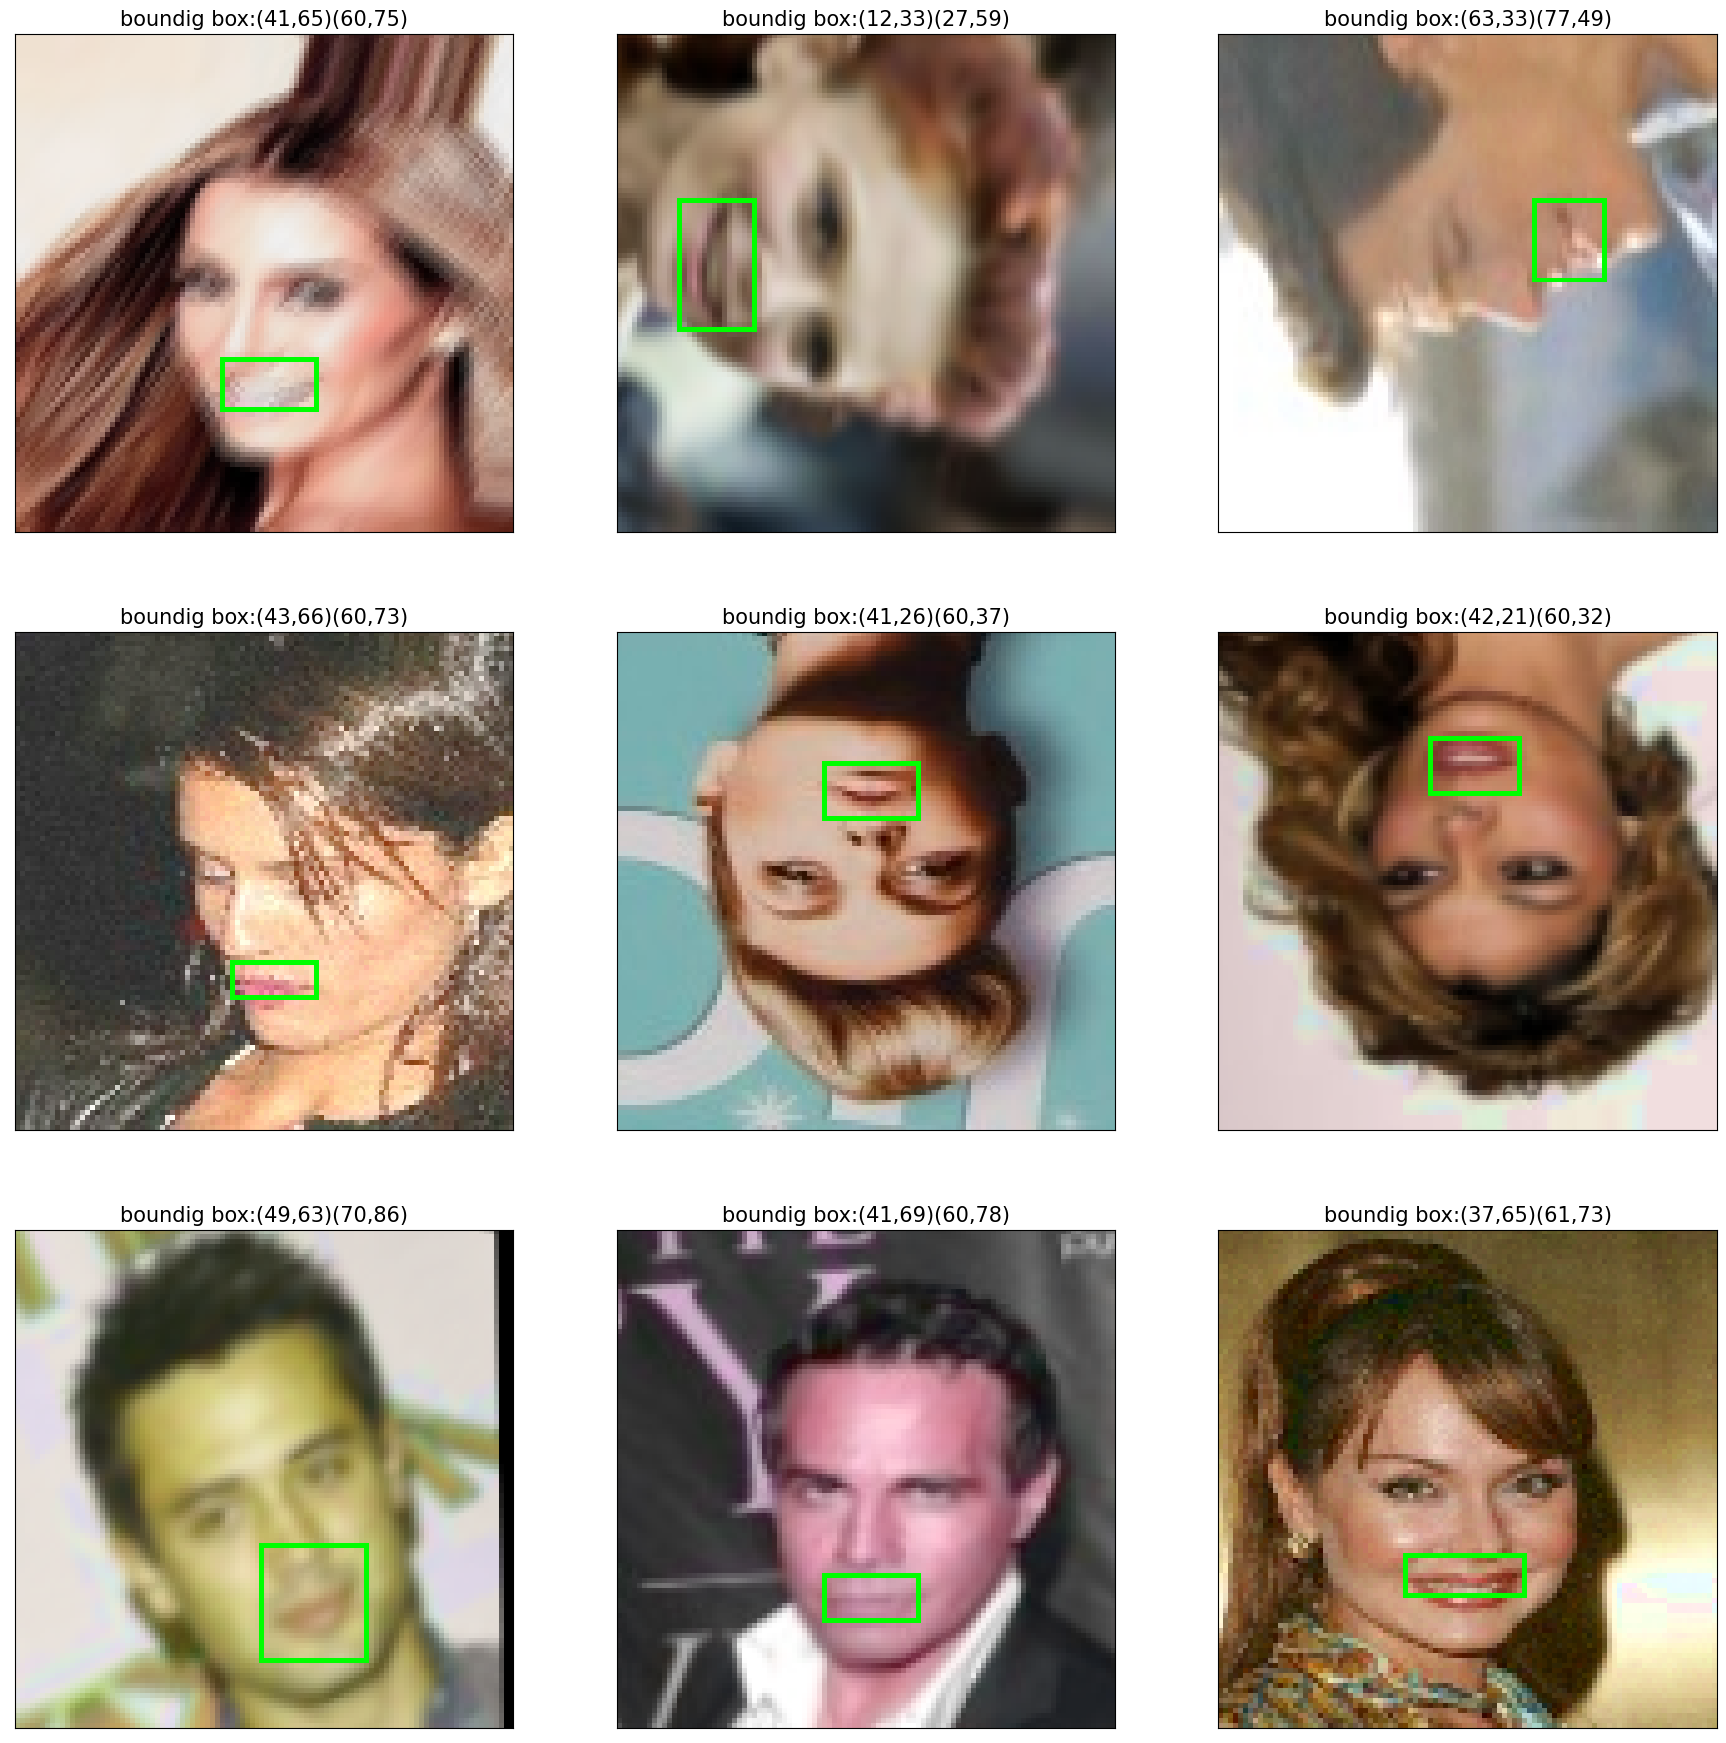

In [48]:
view_augmented_image_from_dataset(train_augmented, 9)


# Batch data

In [49]:
train_no_aug = train_no_aug.batch(BATCH_SIZE)
val_no_aug = val_no_aug.batch(BATCH_SIZE)
test_no_aug = test_no_aug.batch(BATCH_SIZE)


In [50]:
train_augmented = train_augmented.batch(BATCH_SIZE)
val_augmented = val_augmented.batch(BATCH_SIZE)
test_augmented = test_augmented.batch(BATCH_SIZE)


# Create models

## VGG16

In [68]:
vgg = VGG16(
    weights="imagenet",
    include_top=False,
    input_tensor=Input(shape=(IMG_SIZE[0], IMG_SIZE[1], 3)),
)
vgg.trainable = False
flatten = vgg.output
flatten = Flatten()(flatten)

my_layers = Dense(128, activation="relu")(flatten)
my_layers = Dense(64, activation="relu")(my_layers)
my_layers = Dense(32, activation="relu")(my_layers)
my_layers = Dense(4, activation="relu")(my_layers)

model_vgg16 = Model(inputs=vgg.input, outputs=my_layers)
model_vgg16_no_augm = tf.keras.models.clone_model(model_vgg16)

In [75]:
opt = Adam()
model_vgg16.compile(loss="mse", optimizer=opt)
print(model_vgg16.summary())


Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

In [76]:
opt = Adam()
model_vgg16_no_augm.compile(loss="mse", optimizer=opt)
print(model_vgg16_no_augm.summary())

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 100, 100, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 100, 100, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 100, 100, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 50, 50, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 50, 50, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 50, 50, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 25, 25, 128)       0     

## My pure model

In [72]:
model_pure = Sequential()

model_pure.add(
    Conv2D(
        32,
        (3, 3),
        activation="relu",
        padding="same",
        input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3),
    )
)
model_pure.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model_pure.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model_pure.add(Conv2D(128, (3, 3), activation="relu", padding="same"))
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model_pure.add(Conv2D(64, (3, 3), activation="relu", padding="same"))
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model_pure.add(Conv2D(32, (3, 3), activation="relu", padding="same"))
model_pure.add(MaxPooling2D((2, 2)))
model_pure.add(Flatten())
model_pure.add(Dense(128, activation="relu"))
model_pure.add(Dense(64, activation="relu"))
model_pure.add(Dense(32, activation="relu"))
model_pure.add(Dense(4, activation="relu"))
model_pure_no_augm = tf.keras.models.clone_model(model_pure)

In [77]:
opt = Adam()
model_pure.compile(loss="mse", optimizer=opt)
print(model_pure.summary())


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

In [78]:
opt = Adam()
model_pure_no_augm.compile(loss="mse", optimizer=opt)
print(model_pure_no_augm.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 100, 100, 32)      896       
                                                                 
 conv2d_11 (Conv2D)          (None, 100, 100, 32)      9248      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 50, 50, 32)       0         
 2D)                                                             
                                                                 
 conv2d_12 (Conv2D)          (None, 50, 50, 64)        18496     
                                                                 
 conv2d_13 (Conv2D)          (None, 50, 50, 64)        36928     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 25, 25, 64)       0         
 2D)                                                  

## Training

In [79]:
callback = tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=5)


### My model

In [80]:
model_pure.fit(
    train_augmented,
    validation_data=(val_augmented),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callback],
)
model_pure.save("models/model_pure_augm.h5", save_format="h5")


634/634 [==============================] - 354s 558ms/step - loss: 0.1538 - val_loss: 0.1500


In [81]:
model_pure_no_augm.fit(
    train_no_aug,
    validation_data=(val_no_aug),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callback],
)
model_pure_no_augm.save("model_pure_no_augm.h5", save_format="h5")

634/634 [==============================] - 91s 141ms/step - loss: 0.1871 - val_loss: 0.1785


### VGG16

In [82]:
model_vgg16.fit(
    train_augmented,
    validation_data=(val_augmented),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callback],
)
model_vgg16.save("models/model_vgg16_augm.h5", save_format="h5")


272/634 [===========>..................] - ETA: 2:48 - loss: 0.1463

KeyboardInterrupt: 

In [ ]:
tf.keras.backend.clear_session()
model_vgg16_no_augm.fit(
    train_no_aug,
    validation_data=(val_no_aug),
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    verbose=1,
    callbacks=[callback],
)
model_vgg16_no_augm.save("models/model_vgg16_no_augm.h5", save_format="h5")


634/634 [==============================] - 104s 163ms/step - loss: 0.1092 - val_loss: 0.1064


ValueError: Unable to create dataset (name already exists)

# Load saved models

In [66]:
model_pure_no_augm = tf.keras.models.load_model("models/model_pure_no_augm.h5")
model_pure_augm = tf.keras.models.load_model("models/model_pure_augm.h5")
model_vgg16_no_augm = tf.keras.models.load_model("models/model_vgg16_no_augm.h5")
model_vgg16_augm = tf.keras.models.load_model("models/model_vgg16_augm.h5")

models = [model_pure_no_augm, model_pure_augm, model_vgg16_no_augm, model_vgg16_augm]
test_data = [test_no_aug, test_augmented]

models_names = [
    "model_pure_no_augm",
    "model_pure_augm",
    "model_vgg16_no_augm",
    "model_vgg16_augm",
]
test_data_names = ["test_no_aug", "test_augmented"]


OSError: No file or directory found at models/model_pure_augm.h5

# Evaluate models

In [ ]:
results = []
for i, m in enumerate(models):
    for j, t in enumerate(test_data):
        print(f"model: {models_names[i]}    test_data: {test_data_names[j]}")
        results.append(
            {
                "model": models_names[i],
                "test_data": test_data_names[j],
                "loss": m.evaluate(t),
            }
        )

df = pd.DataFrame.from_records(results)
df


In [ ]:
fig = plt.figure(figsize=(20, 10))
ax = sns.barplot(x="model", y="loss", hue="test_data", data=df)
ax.bar_label(ax.containers[0])
ax.bar_label(ax.containers[1])
plt.show()


# Take a look at models predictions

In [ ]:
def draw_bb(preds, img, color=(0, 255, 0)):
    preds = [x * 100 for x in preds]
    x_min, y_min, x_max, y_max = preds
    img_bb = cv2.rectangle(
        np.asarray(img), (int(x_min), int(y_min)), (int(x_max), int(y_max)), color, 1
    )
    return img_bb


In [ ]:
image_aug, label_aug = next(iter(test_augmented))
image_no_aug, label_no_aug = next(iter(test_no_aug))


def view_test_pred(model, image, label, num_model):
    image = image.numpy()
    label = label.numpy()
    preds = model.predict(image)
    fig = plt.figure(figsize=(22, 22))

    for i in range(4):
        ax = fig.add_subplot(1, 4, i + 1, xticks=[], yticks=[])
        img = image[i]
        img = draw_bb(label[i], img, color=(0, 255, 0))
        img = draw_bb(preds[i], img, color=(255, 0, 0))
        ax.set_title(f"{models_names[num_model]}", fontsize=15)
        plt.imshow((img))


## Not augmented pure model - predictions

In [ ]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[0], num_model=0)
view_test_pred(image=image_aug, label=label_aug, model=models[0], num_model=0)


## Augmented pure model - predictions

In [ ]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[1], num_model=1)
view_test_pred(image=image_aug, label=label_aug, model=models[1], num_model=1)


## Not augmented VGG16 model - predictions

In [ ]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[2], num_model=2)
view_test_pred(image=image_aug, label=label_aug, model=models[2], num_model=2)


## Augmented VGG16 model - predictions

In [ ]:
view_test_pred(image=image_no_aug, label=label_no_aug, model=models[3], num_model=3)
view_test_pred(image=image_aug, label=label_aug, model=models[3], num_model=3)


# Predictions on my images

In [ ]:
my_img_dir = "my_img/test/."
l = len(os.listdir(my_img_dir))
temp_bb = [-1, -1, 2, 2]
temp_bb = [temp_bb for i in range(l)]
my_images = tf.keras.utils.image_dataset_from_directory(
    "my_img",
    batch_size=64,
    image_size=(target_height, target_width),
    labels=temp_bb,
    shuffle=False,
)
print(my_images)


In [ ]:
my_images = my_images.map(normalization)
image, label = next(iter(my_images))


In [ ]:
import warnings

warnings.filterwarnings("ignore")
for i, m in enumerate(models):
    view_test_pred(model=m, image=image, label=label, num_model=i)
